In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import random
from sklearn import metrics
from src.reasoner_mod import *
from src.generate import load_dataset, prepare_data, reduce_dataset
from src.reasoner import *
from src.utils import *
from src.vis import *

In [3]:
seed = 2022
dataset_path = 'local/out/dataset/sub-100.json'
ts = timestr()
train_onto, test_onto, data_tr, data_vl, data_te = load_dataset(dataset_path)

In [4]:
data_tr, data_vl, data_te_tr, data_te_vl, idx_te_te, X_te_te, y_te_te = prepare_data(data_tr, data_vl, data_te, seed, 5)

In [5]:
len(data_tr[2])

73531

In [6]:
print(np.mean(data_tr[2]))
data_tr = reduce_dataset(data_tr, len(train_onto), 1600, data_vl)
print(np.mean(data_tr[2]))

0.21888727203492406
0.188546875


In [7]:
type(data_vl)

list

In [8]:
len(data_tr[2])

64000

In [9]:
len(data_te_tr[2])

36735

In [10]:
print(np.mean(data_te_tr[2]))
data_te_tr = reduce_dataset(data_te_tr, len(test_onto), 1400, [idx_te_te, X_te_te, y_te_te])
print(np.mean(data_te_tr[2]))

0.2203348305430788


0.18210714285714286


In [11]:
len(data_te_tr[2])

28000

In [12]:
idx_te_te.extend(data_te_vl[0])
X_te_te.extend(data_te_vl[1])
y_te_te.extend(data_te_vl[2])

In [13]:
len(y_te_te)

3265

In [14]:
print(np.mean(data_tr[2]))
print(np.mean(data_vl[2]))
print()
print(np.mean(data_te_tr[2]))
# print(np.mean(data_te_vl[2]))
print(np.mean(y_te_te))

0.188546875
0.191374246405936

0.18210714285714286
0.18437978560490045


In [15]:
emb_size = 10
hidden_size = 16
epoch_count = 15
test_epoch_count = 10
batch_size = 32
random.seed(seed)
T.manual_seed(seed)
trained_reasoner = ReasonerHead(emb_size=emb_size, hidden_size=hidden_size)
encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in train_onto]

print(f'created reasoner with {paramcount(trained_reasoner)} parameters')
print(f'created {len(encoders)} encoders with {paramcount(encoders[0])} parameters each')
train_logger = train(data_tr, data_vl, trained_reasoner, encoders, epoch_count=epoch_count,
        batch_size=batch_size)

# trained_reasoner.load_state_dict(T.load('local/out/exp/20240723T203043/reasoner.pt'))


created reasoner with 3293 parameters
created 40 encoders with 1270 parameters each
train epoch 00/15 | batch 2001/2000 | loss 0.7230 | val loss 0.7222 | acc 0.1912 | f1 0.3210 | prec 0.1912 | recall 0.9992 | roc auc 0.5402 | pr auc 0.2211 | elapsed 16.75s
train epoch 01/15 | batch 2001/2000 | loss 0.5497 | val loss 0.4514 | acc 0.8176 | f1 0.1220 | prec 0.7736 | recall 0.0662 | roc auc 0.6757 | pr auc 0.3507 | elapsed 58.43s
train epoch 02/15 | batch 2001/2000 | loss 0.4124 | val loss 0.4046 | acc 0.8315 | f1 0.3450 | prec 0.6737 | recall 0.2318 | roc auc 0.7856 | pr auc 0.5263 | elapsed 59.91s
train epoch 03/15 | batch 2001/2000 | loss 0.3120 | val loss 0.3645 | acc 0.8638 | f1 0.5390 | prec 0.7652 | recall 0.4160 | roc auc 0.8298 | pr auc 0.6627 | elapsed 73.28s
train epoch 04/15 | batch 2001/2000 | loss 0.2406 | val loss 0.3384 | acc 0.8776 | f1 0.6232 | prec 0.7581 | recall 0.5291 | roc auc 0.8526 | pr auc 0.7199 | elapsed 71.66s
train epoch 05/15 | batch 2001/2000 | loss 0.1968 |

In [16]:
## --- TESTING
trained_test_encoders = {}
T.manual_seed(seed)
test_logger = TrainingLogger(validate=True, metrics=batch_stats)

for reasoner_name, reasoner in [('trained reasoner', trained_reasoner)]:
    print(reasoner_name)
    T.manual_seed(seed)
    trained_test_encoders[reasoner_name] = test_encoders = [EmbeddingLayer.from_onto(onto, emb_size=emb_size) for onto in test_onto]
    train(data_te_tr, None, reasoner, test_encoders, epoch_count=test_epoch_count, batch_size=batch_size, run_name=reasoner_name, freeze_reasoner=True, logger=test_logger)

trained reasoner
train epoch 00/10 | batch 876/875 | loss 1.3934 | val loss 1.3934 | acc 0.5795 | f1 0.3585 | prec 0.2482 | recall 0.6450 | roc auc 0.6689 | pr auc 0.4583 | elapsed 9.22s
train epoch 01/10 | batch 876/875 | loss 1.1892 | val loss 0.9571 | acc 0.6698 | f1 0.4180 | prec 0.3078 | recall 0.6511 | roc auc 0.7316 | pr auc 0.5231 | elapsed 19.82s
train epoch 02/10 | batch 876/875 | loss 0.8127 | val loss 0.6441 | acc 0.7576 | f1 0.5005 | prec 0.4006 | recall 0.6668 | roc auc 0.7942 | pr auc 0.6027 | elapsed 19.69s
train epoch 03/10 | batch 876/875 | loss 0.5544 | val loss 0.4437 | acc 0.8291 | f1 0.5936 | prec 0.5234 | recall 0.6856 | roc auc 0.8488 | pr auc 0.6917 | elapsed 20.06s
train epoch 04/10 | batch 876/875 | loss 0.3919 | val loss 0.3206 | acc 0.8783 | f1 0.6796 | prec 0.6526 | recall 0.7090 | roc auc 0.8902 | pr auc 0.7733 | elapsed 19.76s
train epoch 05/10 | batch 876/875 | loss 0.2921 | val loss 0.2454 | acc 0.9113 | f1 0.7506 | prec 0.7694 | recall 0.7327 | roc au

In [17]:
with T.no_grad():
    # idx_te, X_te, y_te = data_te
    _, _, Y_te_good = eval_batch(trained_reasoner, trained_test_encoders['trained reasoner'], X_te_te, y_te_te, idx_te_te)
    # _, _, Y_te_rand = eval_batch(random_reasoner, trained_test_encoders['random reasoner'], X_te, y_te, idx_te)

local/out/exp/20240730T133923


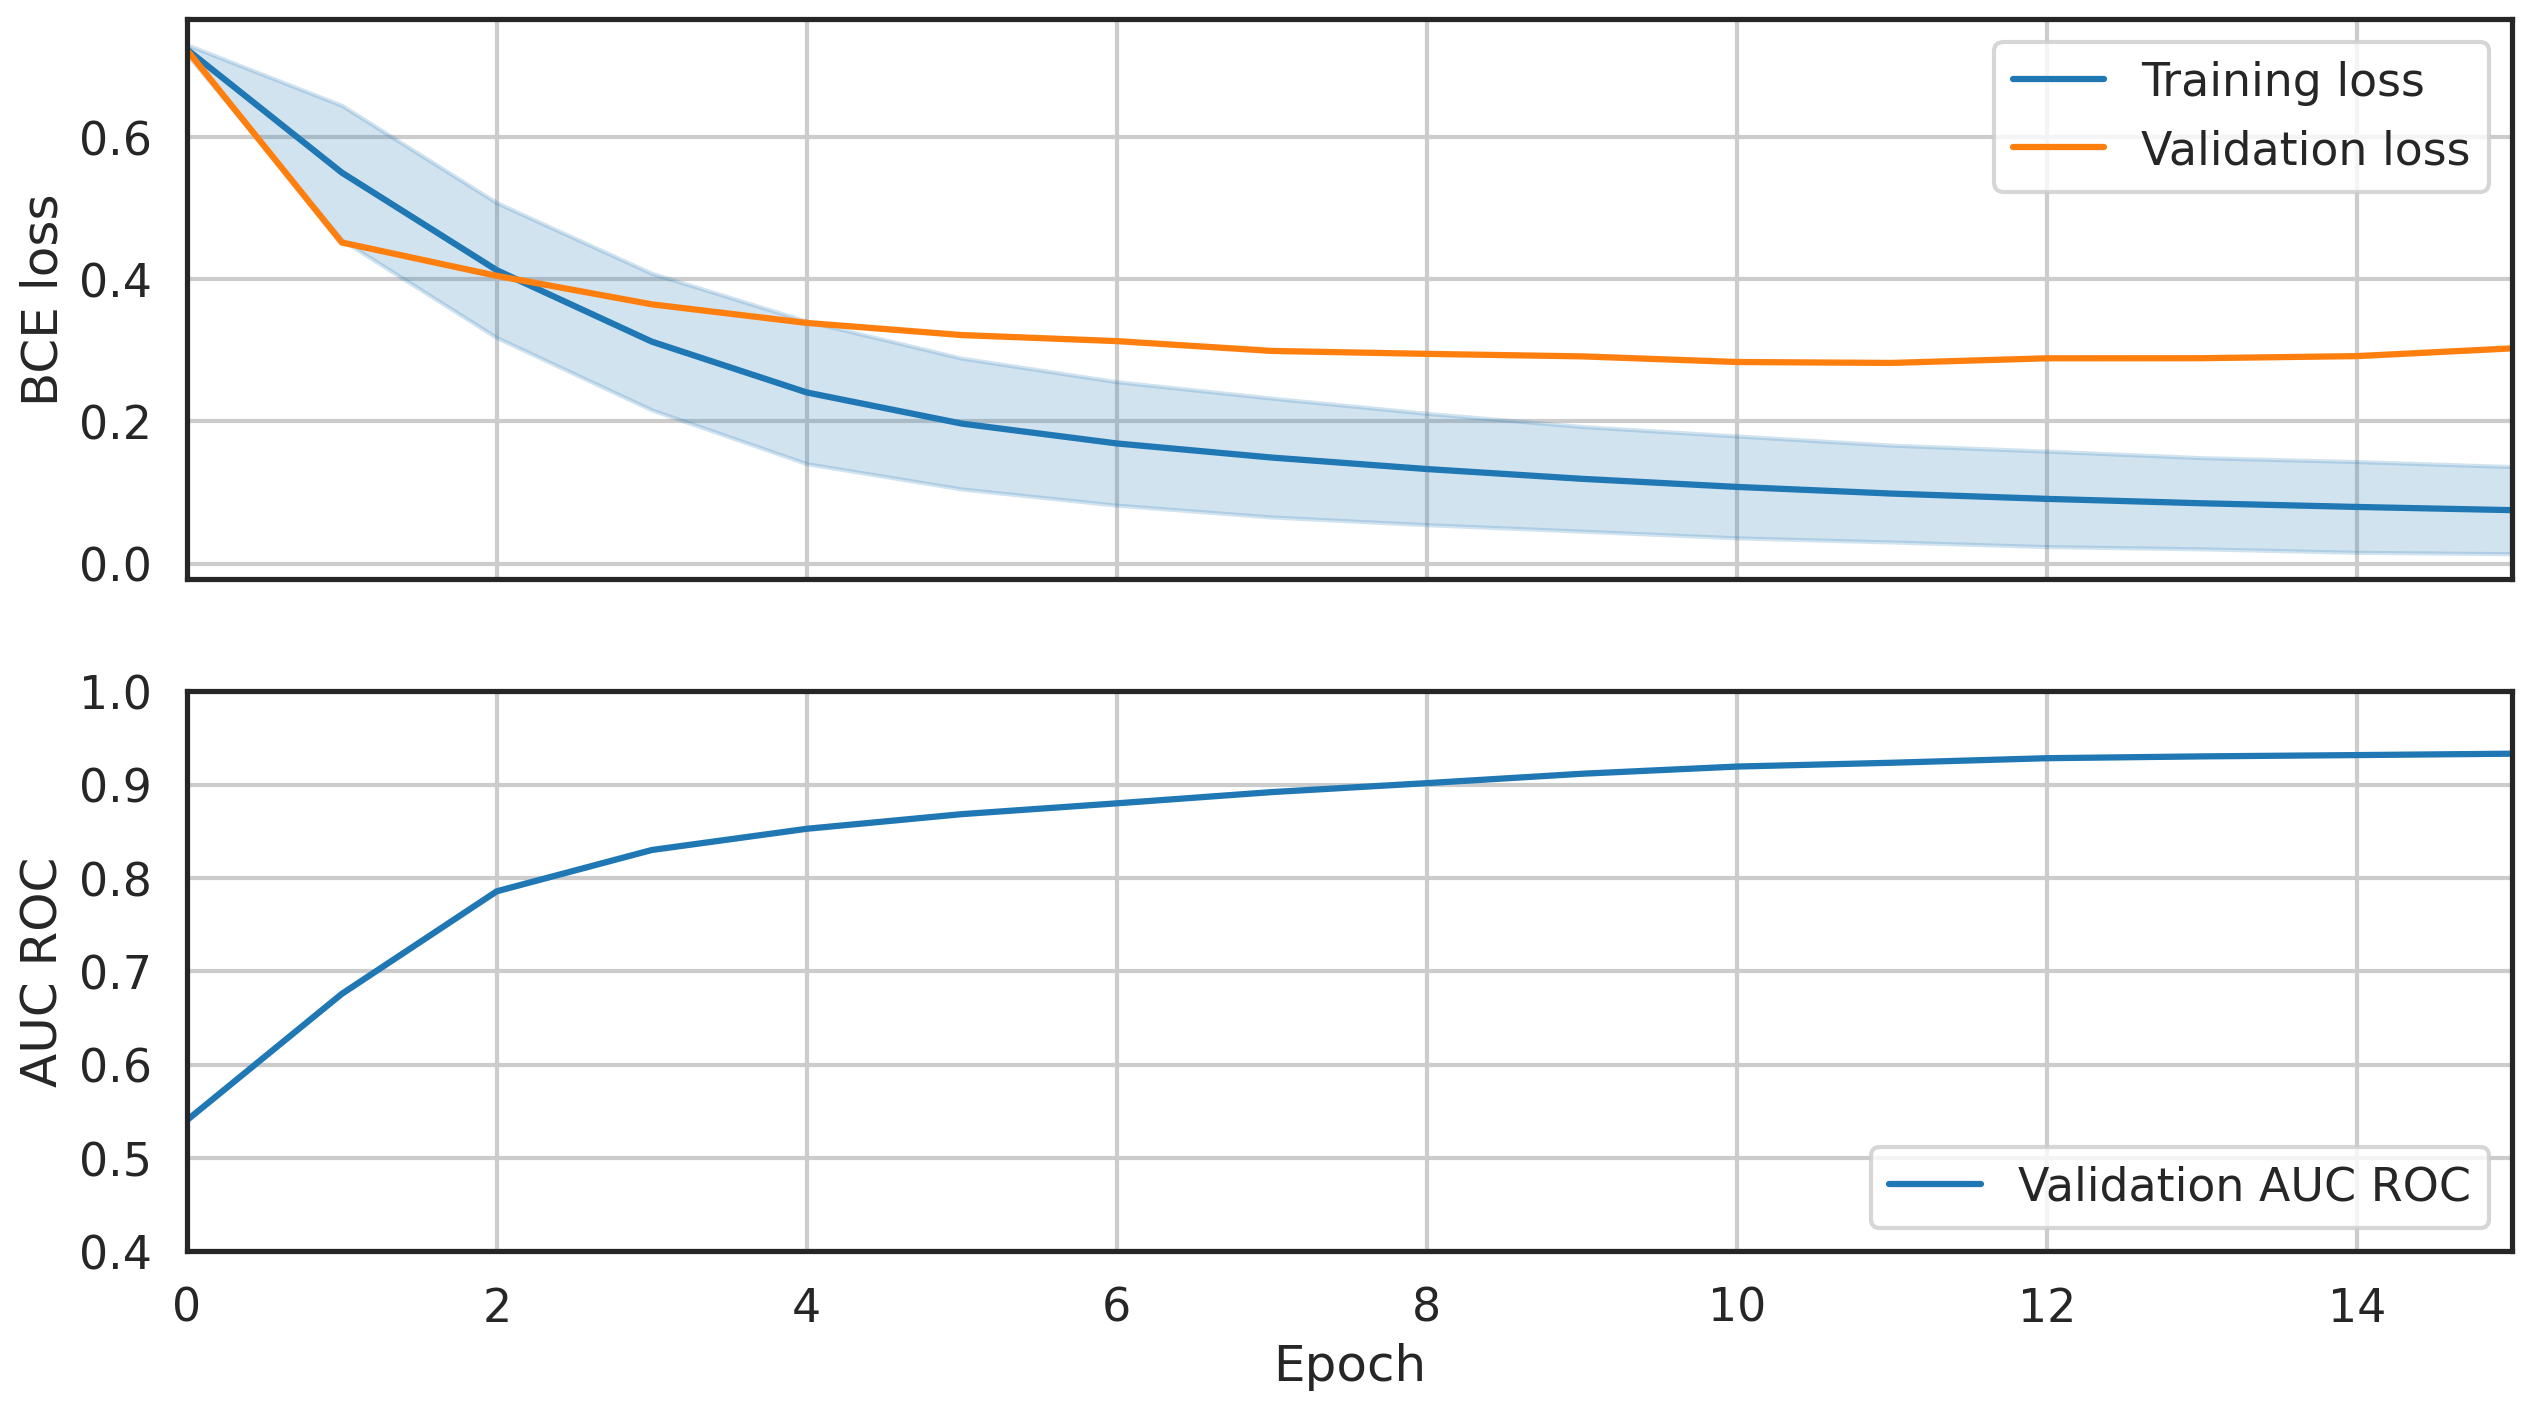

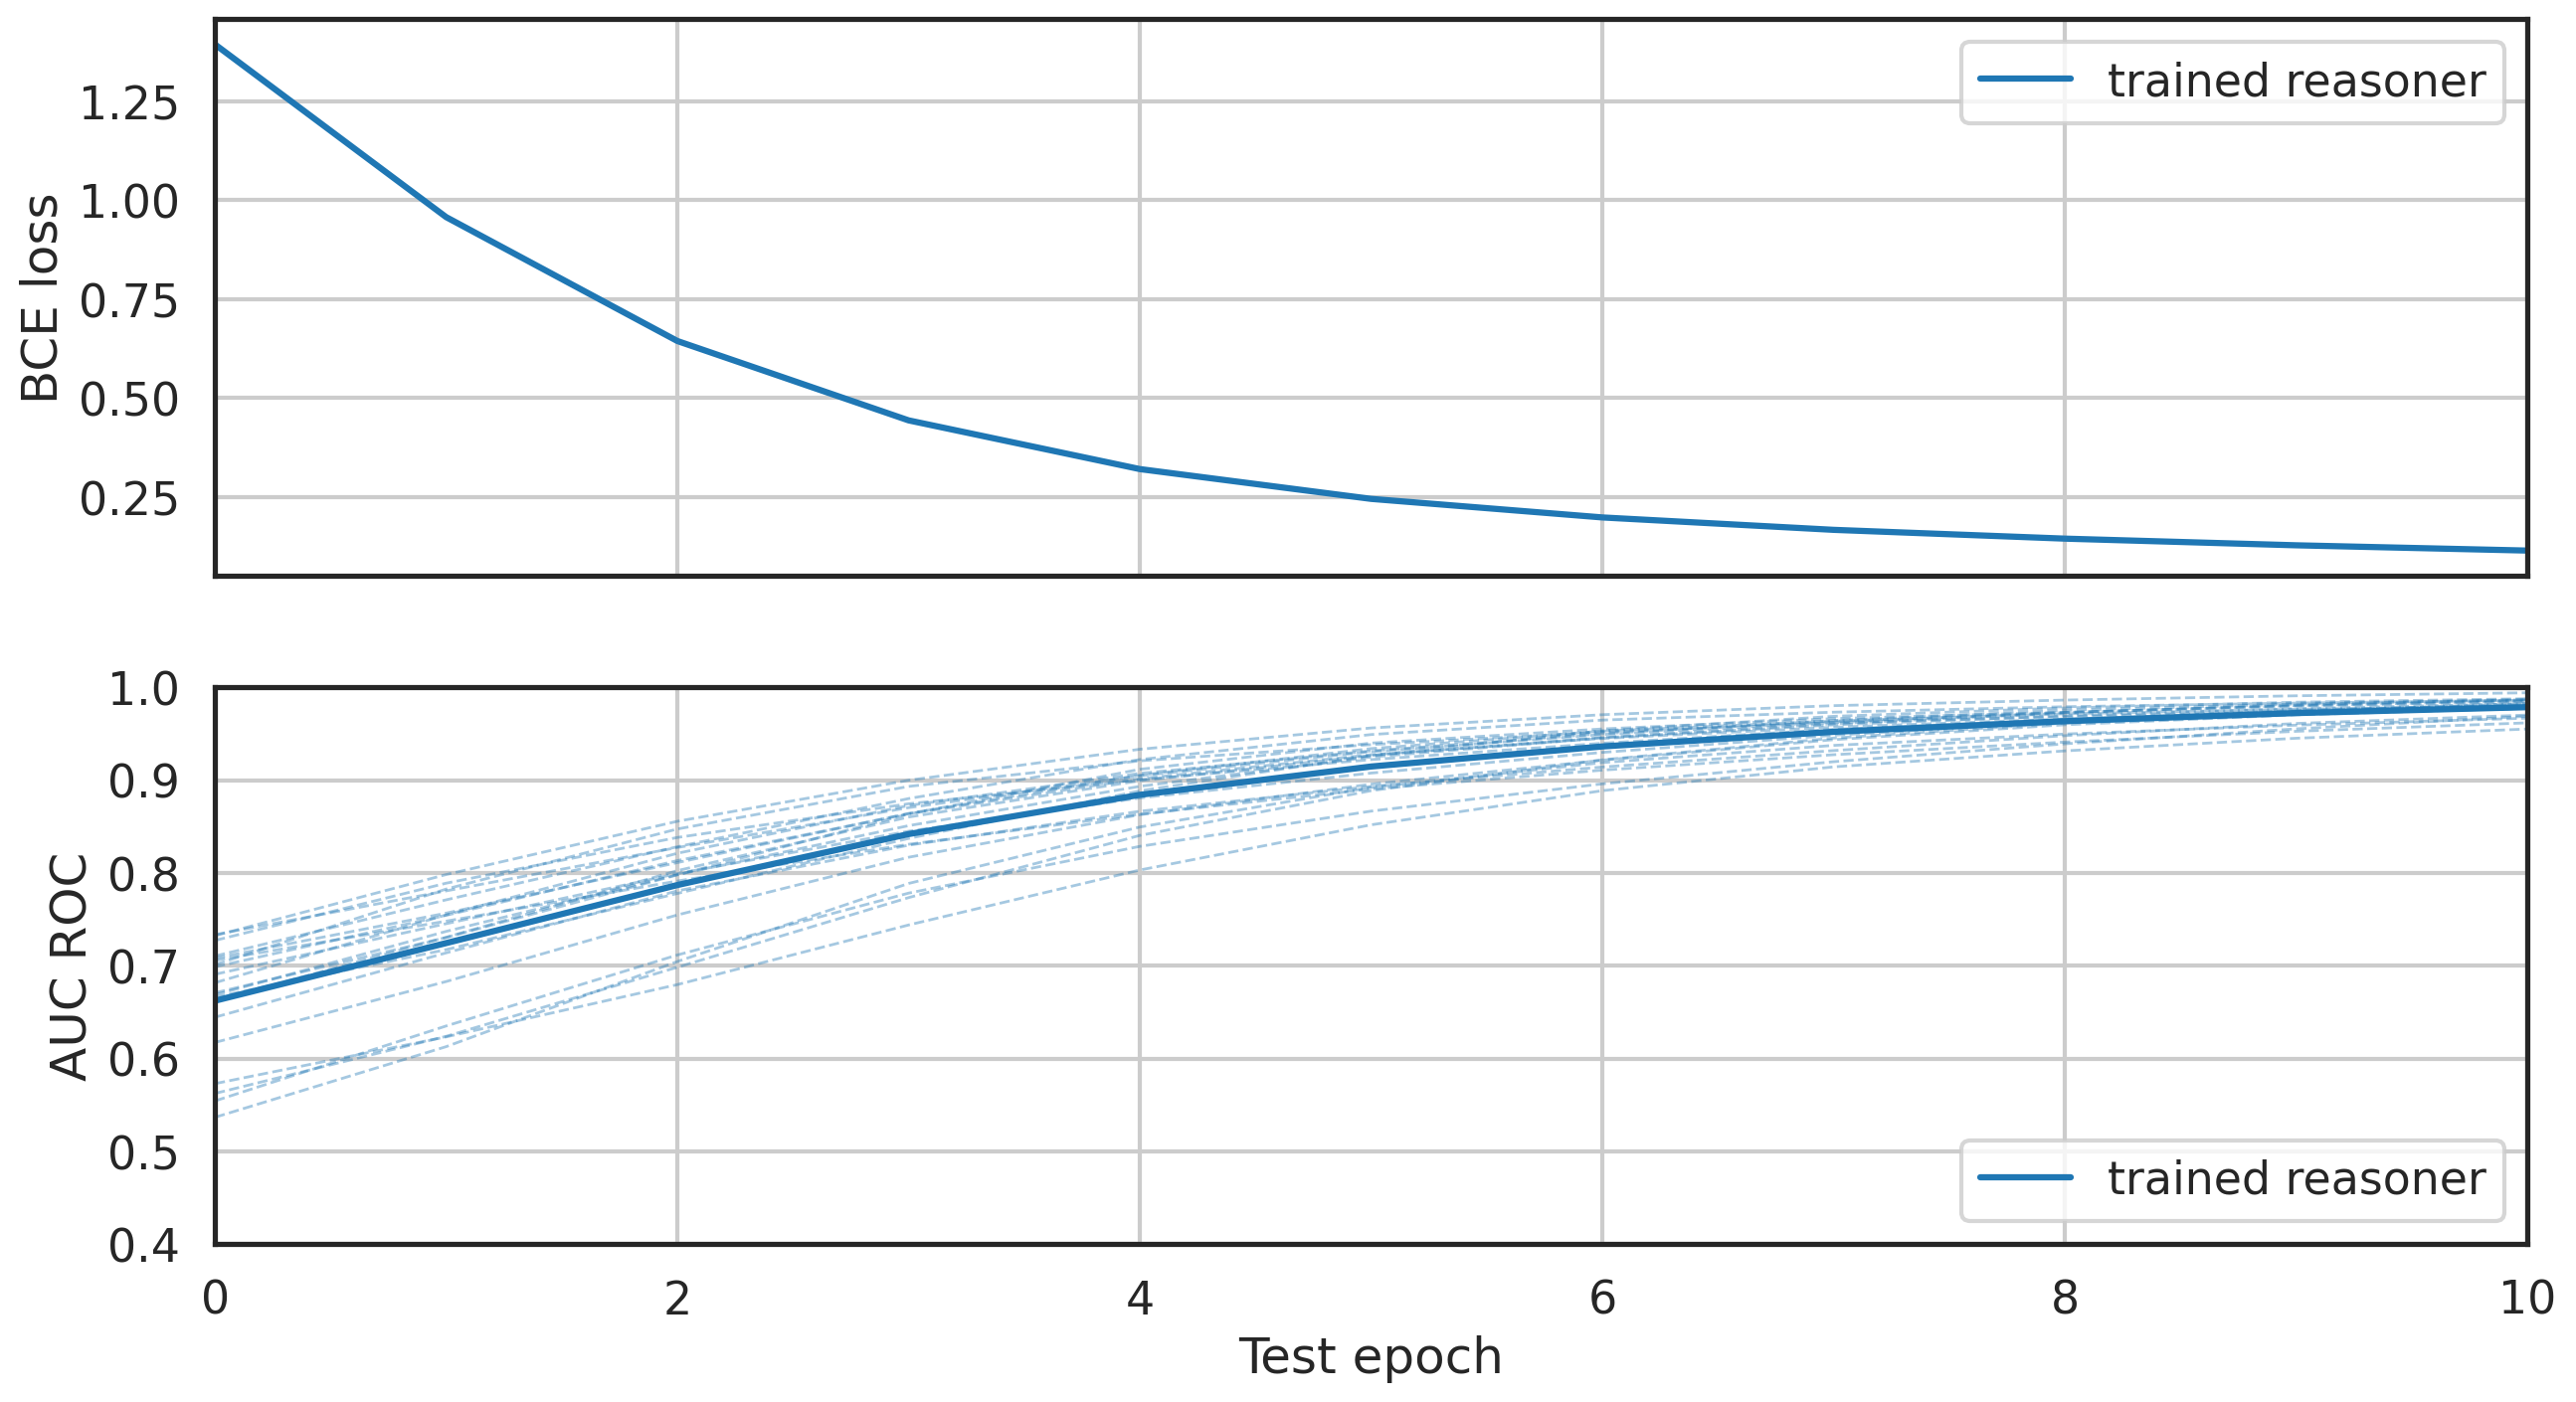

             mean       std     micro
acc      0.882135  0.042943  0.881776
prec     0.697480  0.141123  0.699262
recall   0.612659  0.140768  0.629568
f1       0.644265  0.123868  0.662587
auc_roc  0.873599  0.053016  0.878884
auc_pr   0.738578  0.103308  0.754722


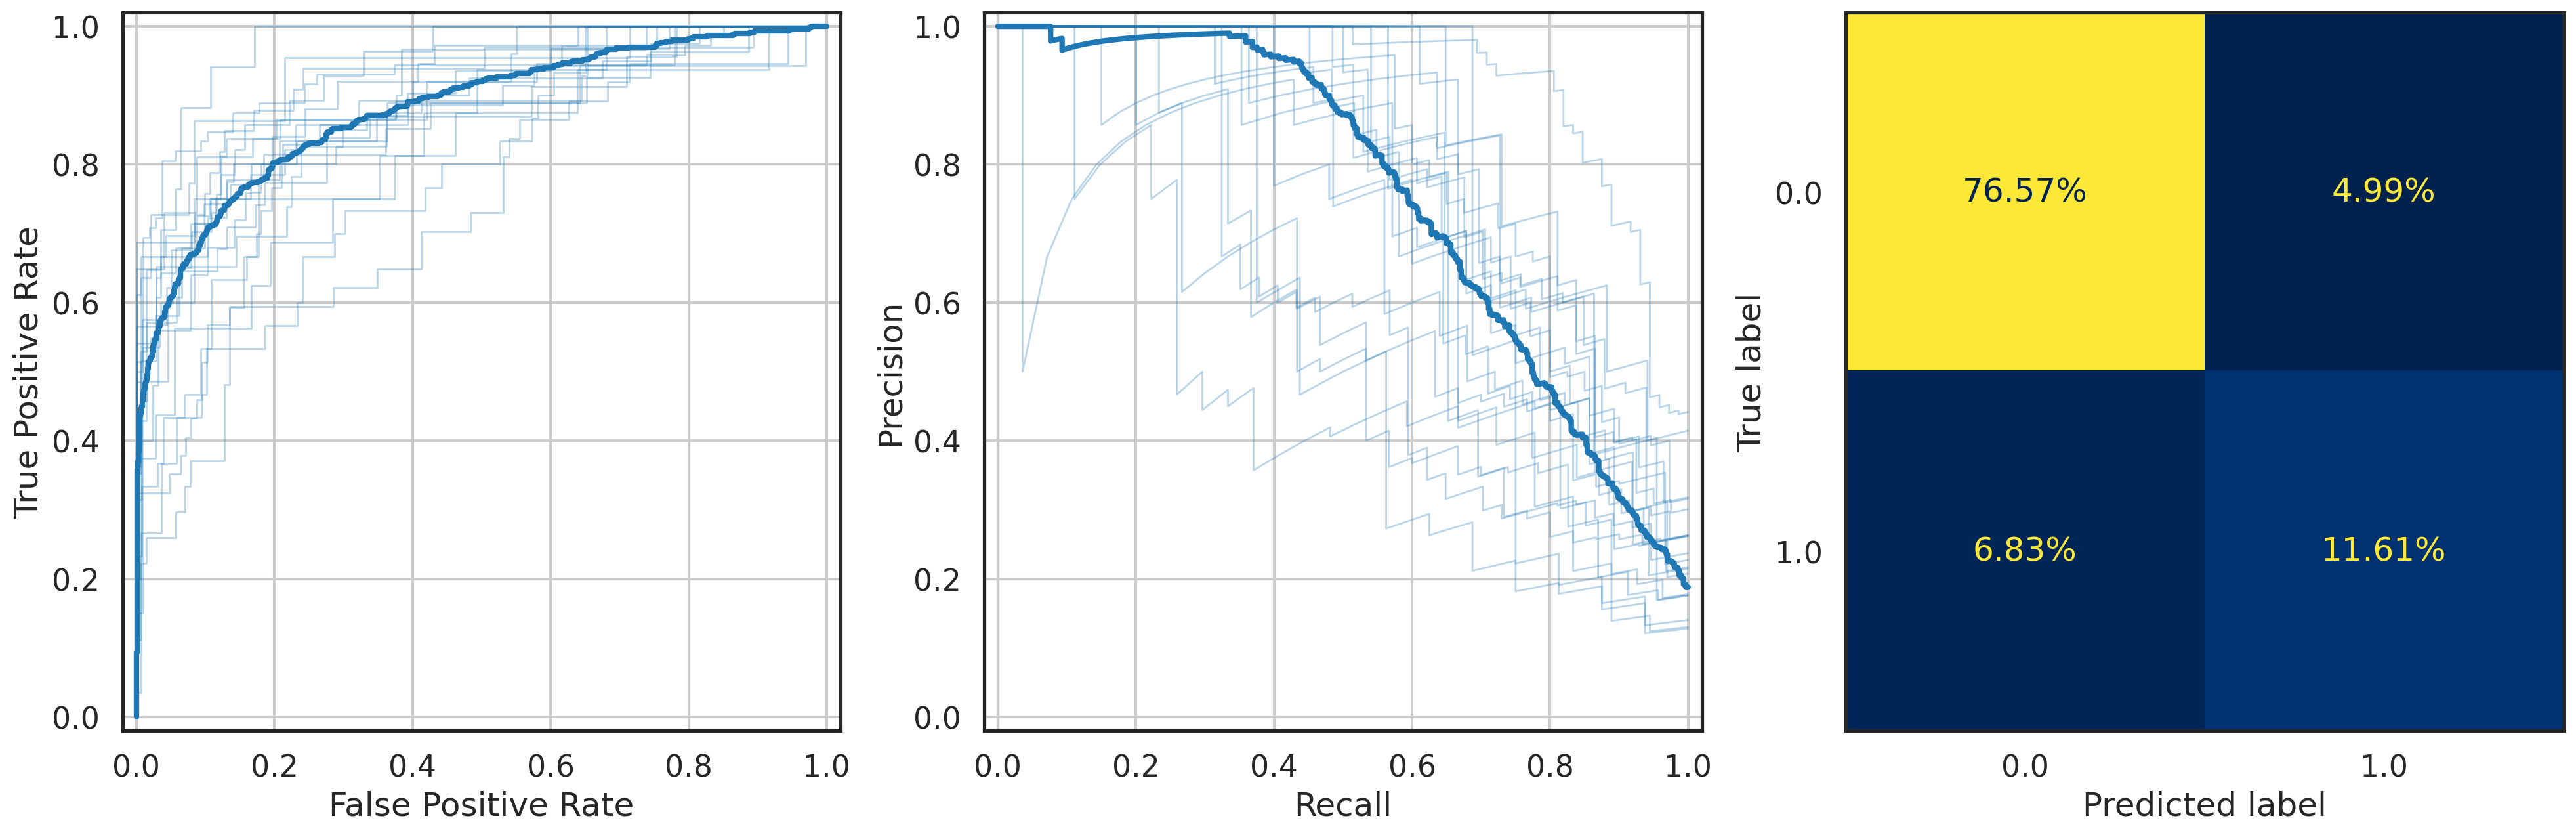

In [18]:
base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

T.save(trained_reasoner.state_dict(), base+'/reasoner.pt')
df_tr = pd.DataFrame(train_logger.history_tr)
df_vl = pd.DataFrame(train_logger.history_vl)
df_tr.to_csv(base+'/train.csv', index=False)
df_vl.to_csv(base+'/valid.csv', index=False)
plot_train_history(df_tr, df_vl, save=base+'/train.png')

test_history_by_onto = pd.DataFrame(test_logger.history_vl_by_onto)
test_history = pd.DataFrame(test_logger.history_vl)
test_results = pd.DataFrame(dict(idx_te=idx_te_te, y_te=y_te_te, Y_te_good=Y_te_good))
test_history.to_csv(base+'/test.csv', index=False)
test_history_by_onto.to_csv(base+'/test-grouped.csv', index=False)
test_results.to_csv(base+'/test-results.csv', index=False)
plot_test_history(test_history, test_history_by_onto)
print(report(test_onto, y_te_te, np.array(Y_te_good), idx_te_te))
# print(report(test_onto, y_te, np.array(Y_te_rand), idx_te))

In [19]:
import random

In [20]:
def max_element_difference(tensor1, tensor2):
    if tensor1.shape != tensor2.shape:
        raise ValueError("Tensory muszą mieć ten sam kształt")
    diff = torch.abs(tensor1 - tensor2)
    max_diff = torch.max(diff).item()
    
    return max_diff

In [21]:
losses_double_negation = []
diffs_double_negation = []

losses_duality = []
diffs_duality = []

losses_duality.append( F.l1_loss(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])).item() )
diffs_duality.append(max_element_difference(trained_reasoner.bot_concept[0], trained_reasoner.not_nn(trained_reasoner.top_concept[0])))

losses_idempotence = []
diffs_idempotence = []
losses_associativity = []
diffs_associativity = []
losses_bot_concept_sub =[]
losses_commutativity = []
diffs_commutativity = []
losses_contradiction = []
diffs_contradiction = []
losses_identity_top = []
diffs_identity_top = []
losses_absorption_bottom = []
diffs_absorption_bottom = []
losses_top_subsumption = []

losses_bot_concept_self = []
diffs_bot_concept_self = []



for _ in range(1000):
    encoder = trained_test_encoders['trained reasoner'][int(np.round(random.random() * (len(trained_test_encoders['trained reasoner'] ) - 1) , 0))]
    input1 = encoder.concepts[int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]
    input2 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    input3 = encoder.concepts[int(np.round(random. random() * encoder.n_concepts, 0) - 1)]
    
    double_negation = trained_reasoner.not_nn(trained_reasoner.not_nn(input1))
    losses_double_negation.append( F.l1_loss(input1, double_negation).item() )
    diffs_double_negation.append(max_element_difference(input1, double_negation))


    idempotence = trained_reasoner.and_nn(im(input1, input1))
    losses_idempotence.append( F.l1_loss(input1, idempotence).item() )
    diffs_idempotence.append(max_element_difference(input1, idempotence))

    
    assoc_left = trained_reasoner.and_nn(im(input1, trained_reasoner.and_nn(im(input2, input3))))
    assoc_right = trained_reasoner.and_nn(im(trained_reasoner.and_nn(im(input1, input2)), input3))
    losses_associativity.append(F.l1_loss(assoc_left, assoc_right).item())
    diffs_associativity.append(max_element_difference(assoc_left, assoc_right))
    
    comm_left = trained_reasoner.and_nn(im(input1, input2))
    comm_right = trained_reasoner.and_nn(im(input2, input1))
    losses_commutativity.append(F.l1_loss(comm_left, comm_right).item())
    diffs_commutativity.append(max_element_difference(comm_left, comm_right))
    
    contradiction = trained_reasoner.and_nn(im(input1, trained_reasoner.not_nn(input1)))
    losses_contradiction.append(F.l1_loss(contradiction, trained_reasoner.bot_concept[0]).item())
    diffs_contradiction.append(max_element_difference(contradiction, trained_reasoner.bot_concept[0]))
    
    identity_top = trained_reasoner.and_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_identity_top.append(F.l1_loss(identity_top, input1).item())
    diffs_identity_top.append(max_element_difference(identity_top, input1))
    
    absorption_bottom = trained_reasoner.and_nn(im(input1, trained_reasoner.bot_concept[0]))
    losses_absorption_bottom.append(F.l1_loss(absorption_bottom, trained_reasoner.bot_concept[0]).item())
    diffs_absorption_bottom.append(max_element_difference(absorption_bottom, trained_reasoner.bot_concept[0]))
    
    top_subsumption = trained_reasoner.sub_nn(im(input1, trained_reasoner.top_concept[0]))
    losses_top_subsumption.append(1 - T.sigmoid(top_subsumption).item())
    
    losses_bot_concept_sub.append(1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], input1))).item())

    losses_bot_concept_self.append( 1 - T.sigmoid(trained_reasoner.sub_nn(im(trained_reasoner.bot_concept[0], trained_reasoner.bot_concept[0]))).item() )


In [22]:
import numpy as np

def print_results(name, losses, diffs):
    print(f"{name}:")
    print(f"  Mean Loss: {np.mean(losses):.6f}")
    print(f"  Std Dev Loss: {np.std(losses):.6f}")
    if diffs:
        print(f"  Mean Diff: {np.mean(diffs):.6f}")
        print(f"  Std Dev Diff: {np.std(diffs):.6f}")
    else:
        print("  Mean Diff: N/A")
        print("  Std Dev Diff: N/A")
    print()

# Print results for each identity
print_results("Double Negation", losses_double_negation, diffs_double_negation)
print_results("Duality of Top and Bottom", losses_duality, diffs_duality)
print_results("Idempotence", losses_idempotence, diffs_idempotence)
print_results("Associativity", losses_associativity, diffs_associativity)
print_results("Commutativity", losses_commutativity, diffs_commutativity)
print_results("Contradiction", losses_contradiction, diffs_contradiction)
print_results("Identity with Top", losses_identity_top, diffs_identity_top)
print_results("Absorption by Bottom", losses_absorption_bottom, diffs_absorption_bottom)
print_results("Top Concept Subsumption", losses_top_subsumption, [])
print_results("Bottom Concept Subsumption", losses_bot_concept_sub, [])
print_results("Bottom Concept Self-Subsumption", losses_bot_concept_self, [])


Double Negation:
  Mean Loss: 0.275811
  Std Dev Loss: 0.032712
  Mean Diff: 0.563180
  Std Dev Diff: 0.097551

Duality of Top and Bottom:
  Mean Loss: 0.373931
  Std Dev Loss: 0.000000
  Mean Diff: 0.720575
  Std Dev Diff: 0.000000

Idempotence:
  Mean Loss: 0.125803
  Std Dev Loss: 0.032512
  Mean Diff: 0.310137
  Std Dev Diff: 0.084550

Associativity:
  Mean Loss: 0.034462
  Std Dev Loss: 0.011972
  Mean Diff: 0.078473
  Std Dev Diff: 0.026491

Commutativity:
  Mean Loss: 0.037533
  Std Dev Loss: 0.012918
  Mean Diff: 0.087900
  Std Dev Diff: 0.032977

Contradiction:
  Mean Loss: 0.380851
  Std Dev Loss: 0.016583
  Mean Diff: 0.827669
  Std Dev Diff: 0.069834

Identity with Top:
  Mean Loss: 0.146908
  Std Dev Loss: 0.037700
  Mean Diff: 0.358825
  Std Dev Diff: 0.115161

Absorption by Bottom:
  Mean Loss: 0.416149
  Std Dev Loss: 0.021125
  Mean Diff: 0.792045
  Std Dev Diff: 0.040520

Top Concept Subsumption:
  Mean Loss: 0.001102
  Std Dev Loss: 0.001227
  Mean Diff: N/A
  Std De